# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

In [113]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

### Анализ требований

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

**Моя задача:** построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.

Знакомство с данными

In [114]:
churn = pd.read_csv('churn.csv')
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Набор данных содержит следующие столбцы
* RowNumber — номер строки таблицы;
* CustomerId — идентификатор клиента;
* Surname — фамилия клиента;
* CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
* Geography — страна проживания клиента (банк межнациональный);
* Gender — пол клиента;
* Age — возраст клиента;
* Tenure — сколько лет клиент пользуется банком;
* Balance — сколько у клиента денег на счетах в банке;
* NumOfProduct — число услуг банка, которыми воспользовался клиент;
* HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
* IsActiveMember — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);
* EstimatedSalary — предполагаемая заработная плата клиента;
* Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

In [115]:
churn.shape

(10000, 14)

In [116]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [117]:
churn.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [118]:
churn.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Пропусков в данных нет

### Исследование данных

In [119]:
churn.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
client = churn.copy()

Поведем разведывательный анализ данных. Построим графики

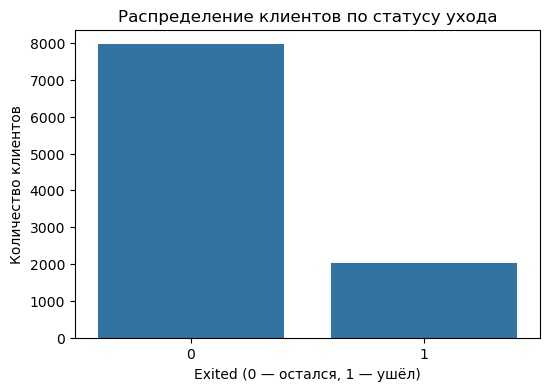

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=client)
plt.title('Распределение клиентов по статусу ухода')
plt.xlabel('Exited (0 — остался, 1 — ушёл)')
plt.ylabel('Количество клиентов')
plt.show()

Мы видим, что большинство клиентов остаются в банке.

Text(0.5, 1.0, 'Распределение уходов по странам')

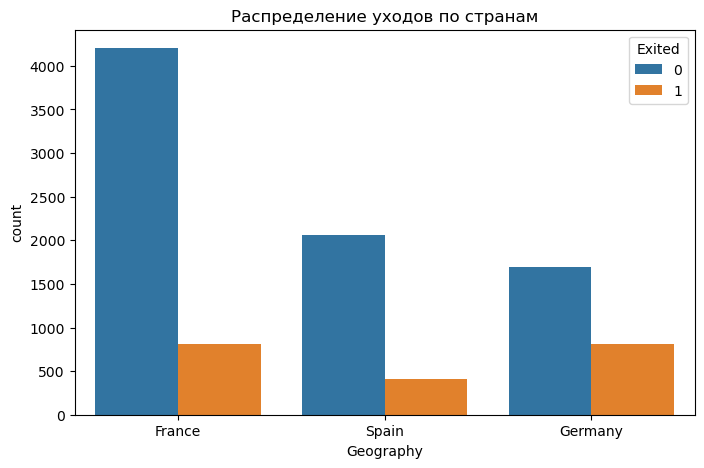

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Geography', hue='Exited', data=client)
plt.title('Распределение уходов по странам')

Клиенты из Германии уходят чаще, чем из Франции или Испании.

<Axes: xlabel='Gender', ylabel='count'>

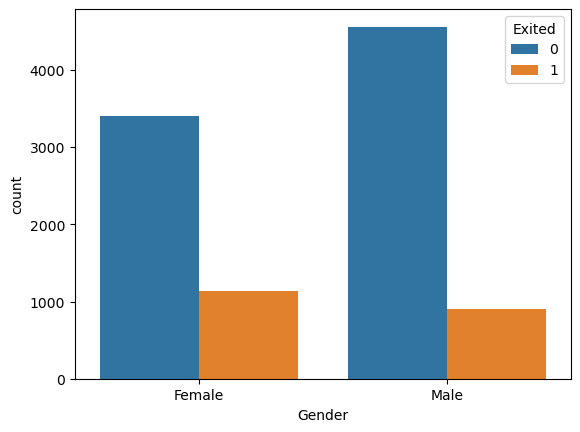

In [ ]:
sns.countplot(x='Gender', hue='Exited', data=client)

Женщины уходят чаще мужчин

Text(0.5, 1.0, 'Влияние кредитного рейтинга на уход клиентов')

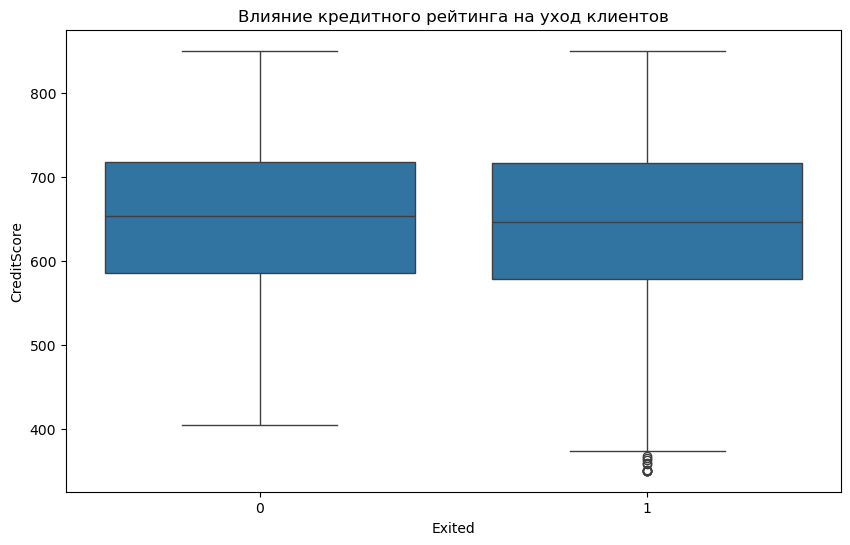

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Exited', y='CreditScore', data=client)
plt.title('Влияние кредитного рейтинга на уход клиентов')

Люди которые имеют низкий рейтинг уходят чаще из банка

<Axes: xlabel='Age', ylabel='Count'>

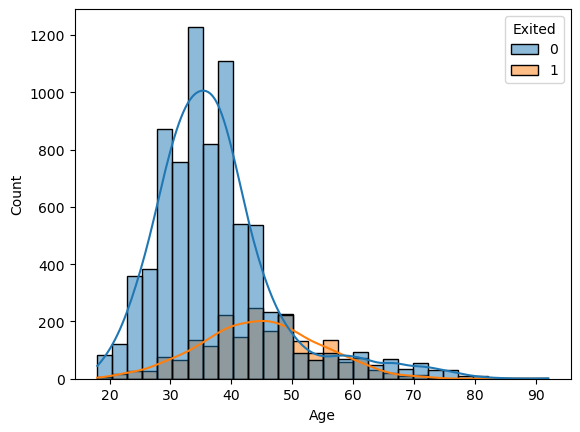

In [ ]:
sns.histplot(data=client, x='Age', hue='Exited', kde=True, bins=30)

Пик уходов среди клиентов, обычно в возрасте 40-50 лет

<Axes: xlabel='Exited', ylabel='Balance'>

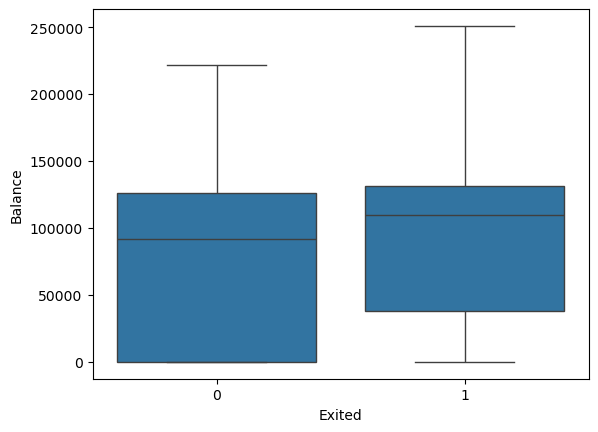

In [ ]:
sns.boxplot(x='Exited', y='Balance', data=client)

Люди имеющие большие счета в банке, уходят чаще.

<Axes: xlabel='Age', ylabel='EstimatedSalary'>

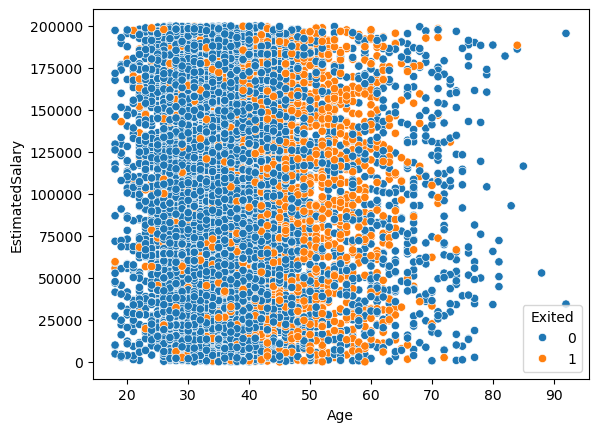

In [ ]:
sns.scatterplot(x='Age', y='EstimatedSalary', hue='Exited', data=client)

<Axes: xlabel='NumOfProducts', ylabel='count'>

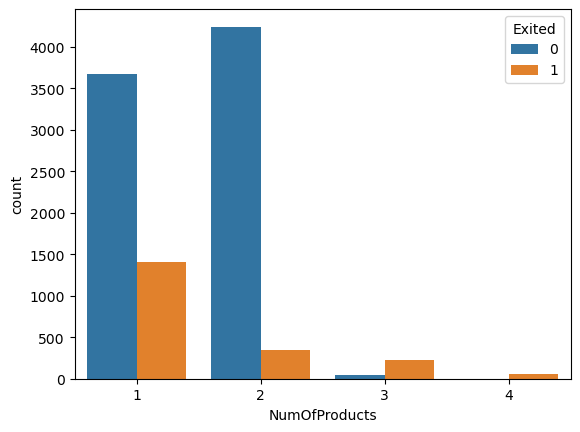

In [ ]:
sns.countplot(x='NumOfProducts', hue='Exited', data=client)

<Axes: xlabel='IsActiveMember', ylabel='Exited'>

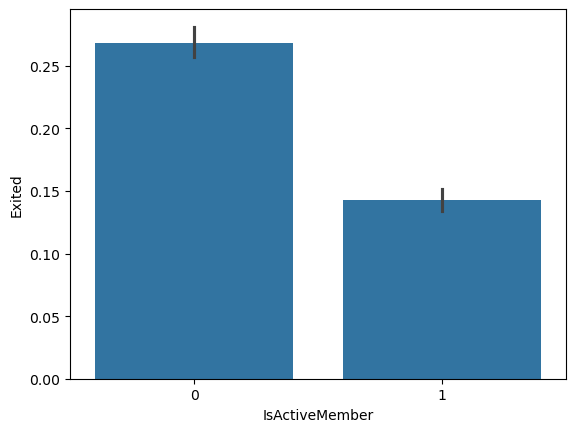

In [ ]:
sns.barplot(x='IsActiveMember', y='Exited', data=client)

Неактивные клиенты уходят в 2 раза чаще

Также посмотрим какой у нас дисбаланс классов.

<Axes: ylabel='count'>

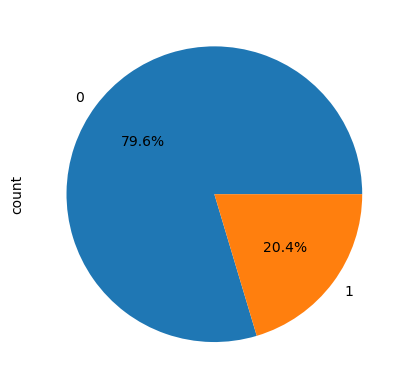

In [ ]:
client['Exited'].value_counts().plot.pie(autopct='%1.1f%%')

### Подготовка данных

Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Выделим только данные, относящиеся к Германии:

In [ ]:
client = client[client['Geography'] == 'Germany']

In [ ]:
client.shape

(2509, 14)

Можно сразу избавиться от нескольких признаков: Страна, номер строки, индификатор пользователя и имя клиента, так как они неинформативны

In [ ]:
client = client.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

<Axes: ylabel='count'>

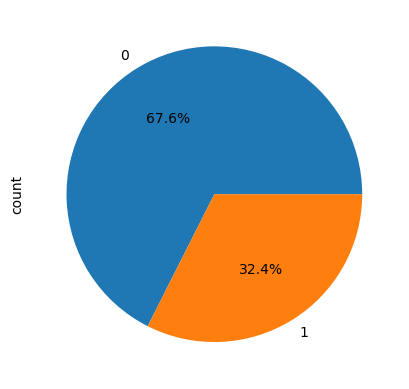

In [ ]:
client['Exited'].value_counts().plot.pie(autopct='%1.1f%%')

Дисбаланс немного уменьшился. Однако дисбаланс все равно приличный. 32 к 67, почти в два раза разница.

Проверим данные на дубликаты

In [ ]:
client[client.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

In [ ]:
churn = client.copy()

Расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

In [ ]:
client['BalanceSalaryRatio'] = client['Balance'] / client['EstimatedSalary']
client['TenureByAge'] = client['Tenure'] / client['Age']
client['CreditScoreGivenAge'] = client['CreditScore'] / client['Age']

client['Gender'] = client['Gender'].apply(lambda x: 0 if x == 'Female' else 1)

In [ ]:
client.reset_index(drop=True)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
0,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
1,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
2,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
3,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
4,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504,655,0,46,7,137145.12,1,1,0,115146.40,1,1.191050,0.152174,14.239130
2505,602,1,35,7,90602.42,2,1,1,51695.41,0,1.752620,0.200000,17.200000
2506,673,1,47,1,183579.54,2,0,1,34047.54,0,5.391859,0.021277,14.319149
2507,714,1,33,3,35016.60,1,1,0,53667.08,0,0.652478,0.090909,21.636364


In [ ]:
client.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,0.524512,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487
std,98.168937,0.499498,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558
min,350.000000,0.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676
25%,584.000000,0.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275
50%,651.000000,1.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143
75%,722.000000,1.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941
max,850.000000,1.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889


Разделим данные

In [ ]:
churn = client.copy()


In [142]:
X = churn.drop('Exited', axis=1)
y = churn['Exited']

Как мы помним, классы у нас не сбалансированны. Это может привести к тому, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным. Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y.

In [143]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим дисбаланс

<Axes: ylabel='count'>

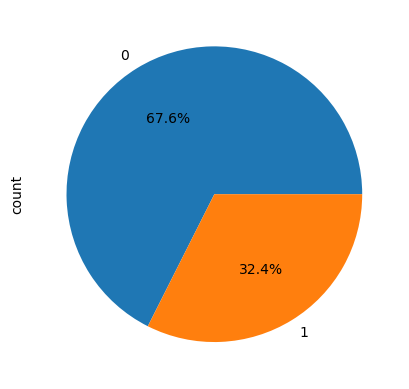

In [144]:
y_train.value_counts().plot.pie(autopct='%1.1f%%')

<Axes: ylabel='count'>

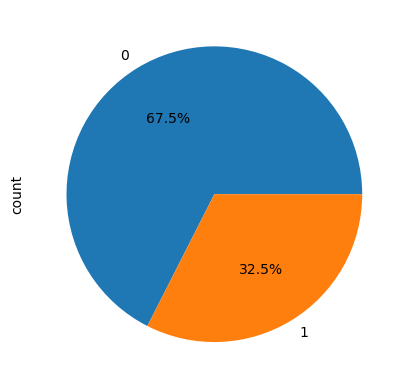

In [145]:
y_test.value_counts().plot.pie(autopct='%1.1f%%')

Соотношения получились одинаковыми, а значит, мы можем идти дальше.

## Логистическая регрессия

Т.к мы собираемся использовать модель логистической регрессии, то нам нужно нормализировать\ стандартизировать данные. Посмотрим на распределения данных и решим, что мы будем с ними делать.

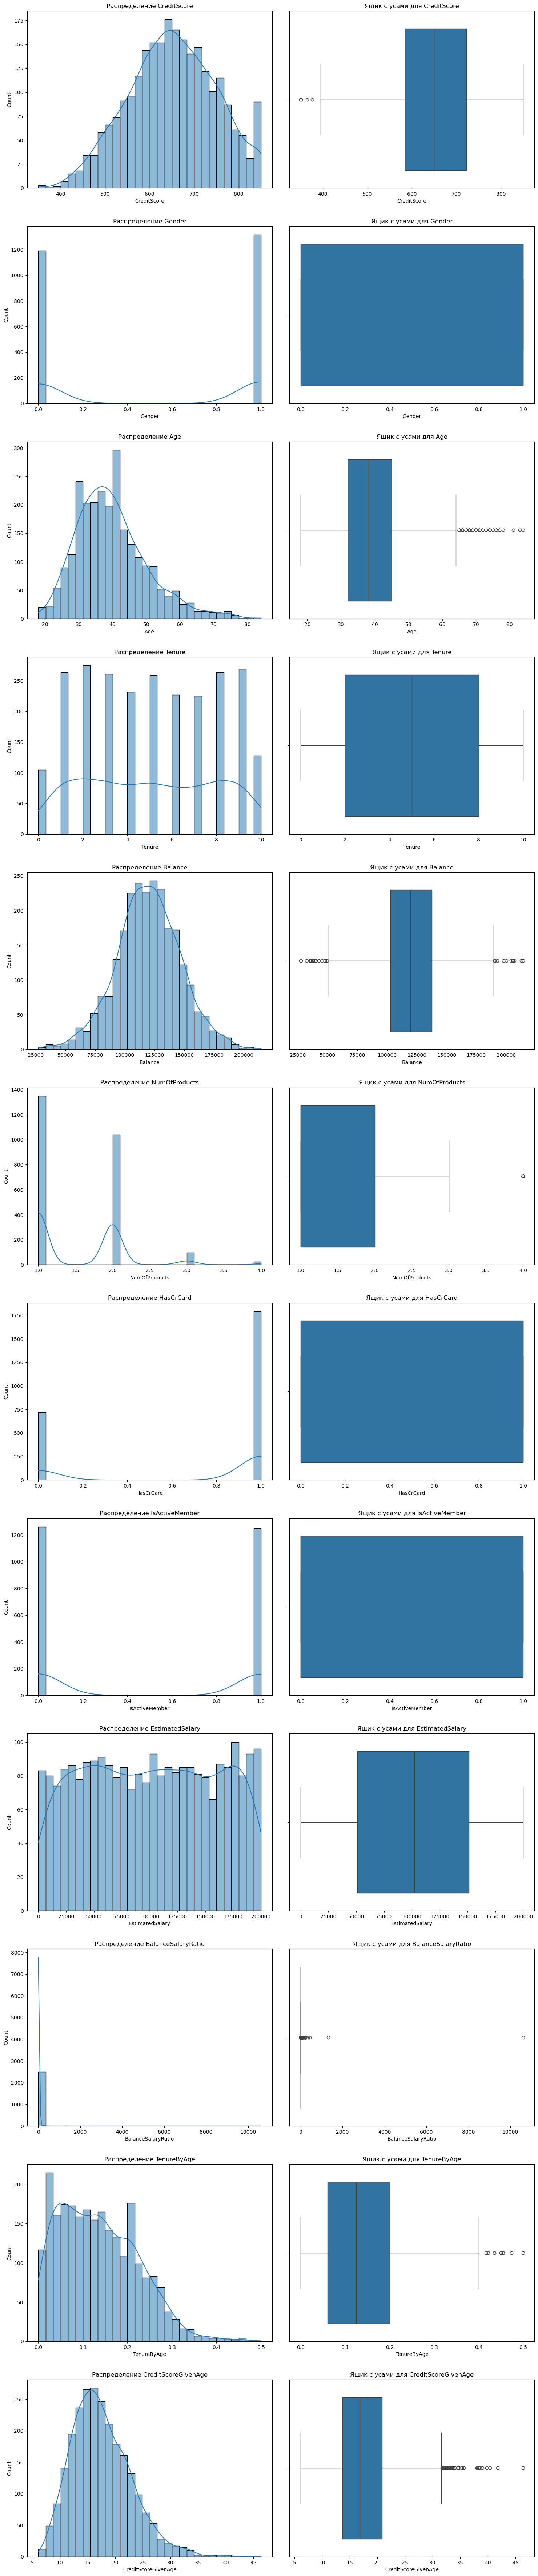

In [150]:
fig, axes = plt.subplots(nrows=X.shape[1], ncols=2, figsize=(16, 6 * X.shape[1])) 

for i, col in enumerate(X.columns):
    # Гистограмма
    sns.histplot(X[col], ax=axes[i, 0], kde=True, bins=30)
    axes[i, 0].set_title(f'Распределение {col}')
    
    # Boxplot
    sns.boxplot(x=X[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Ящик с усами для {col}')

plt.tight_layout(pad=5.0, h_pad=3.0, w_pad=3.0)

Будем использовать стандартизацию, так как она лучше всего подходит для моделей логистической регрессии

In [154]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_test)
X_test_std = scaler.transform(X_test)
X_train_std = scaler.transform(X_train)

### Моделирование


Выберим метрику оценивания
По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

> По моему мнению, в данной задаче нам следует использовать метрику F1-Score, так как она учитывает баланс между метриками Precision(меньше ложный срабатываний = экономия ресурсов колл-центра) и Recall( меньше пропущенных уходов = сохраняем клиентов). Также она учитывает дисбаланс классов. 


In [224]:
log_model = linear_model.LogisticRegression(random_state=42, penalty='l1', solver='liblinear')
log_model.fit(X_train_std, y_train)

y_pred_train = log_model.predict(X_train_std)
y_pred_test = log_model.predict(X_test_std)

print(f'F1-Score для тренировочной выборки: {metrics.f1_score(y_train, y_pred_train)}')
print(f'F1-Score для тестовой выборки: {metrics.f1_score(y_test, y_pred_test)}')

F1-Score для тренировочной выборки: 0.5135135135135135
F1-Score для тестовой выборки: 0.4942528735632184


Значение крайне малы. Максимум который я добился методом тыка, представлены выше. Можно попробовать подобрать оптимальные значение C, а также увеличить количество иттераций, т.к по умолчанию оно равно 100.

Попробуем сгенерировать полиномиальные признаки 3 степени. Посмотрим, какой нам это даст результат.

In [196]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_std)
X_train_std_poly = poly.transform(X_train_std)
X_test_std_poly = poly.transform(X_test_std)


In [198]:
log_model_2 = linear_model.LogisticRegression(random_state=42)
log_model_2.fit(X_train_std_poly, y_train)

y_pred_train_2 = log_model.predict(X_train_std_poly)
y_pred_test_2 = log_model.predict(X_test_std_poly)

print(f'F1-Score для тренировочной выборки: {metrics.f1_score(y_train, y_pred_train_2)}')
print(f'F1-Score для тестовой выборки: {metrics.f1_score(y_test, y_pred_test_2)}')

F1-Score для тренировочной выборки: 0.7788378143972247
F1-Score для тестовой выборки: 0.6528497409326425


/home/bismu/anaconda3/envs/aono-ds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Благодаря полиному 3 степени, мы смогли улучшить предсказание модели.

Попробуем подобрать для модели значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке.

In [200]:
tresholds = np.arange(0.1, 1, 0.05)

y_test_proba_pred = pd.Series(log_model_2.predict_proba(X_test_std_poly)[:, 1])
scores = []
for treshold in tresholds:
    y_pred_test_2 = y_test_proba_pred.apply(lambda x: 1 if x > treshold else 0)
    score = metrics.f1_score(y_test, y_pred_test_2)
    scores.append(score) 

Строим график

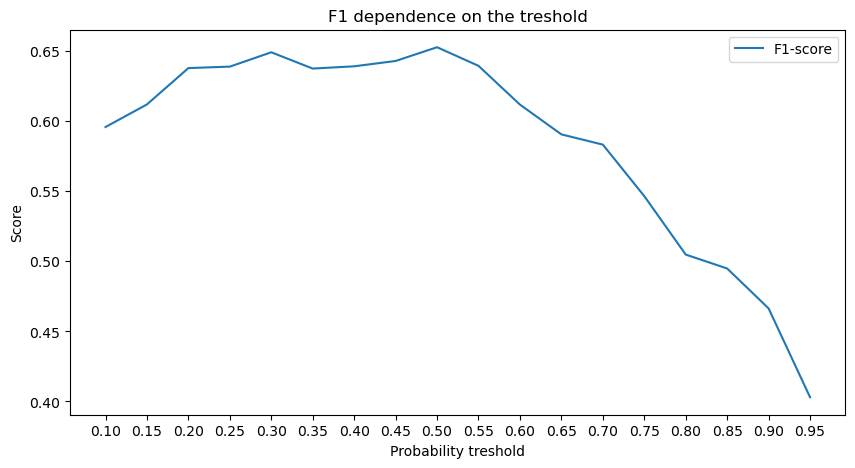

In [203]:
fig, ax = plt.subplots(figsize=(10,5))
#Строим линейный график зависимости F1 от threshold
ax.plot(tresholds, scores, label='F1-score')
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the treshold')
ax.set_xlabel('Probability treshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(tresholds)
#Отображаем легенду
ax.legend();


In [205]:
best_idx = np.argmax(scores)
best_treshold = tresholds[best_idx]
print(best_treshold)

0.5000000000000001


Самый лучший результат при пороге вероятности = 0.5. Он у нас установлен по умолчанию

## Дерево решений и Случайный лес

In [236]:
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем нужные библиотеки

In [237]:
from sklearn import tree
from sklearn import ensemble

In [238]:
classifier_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
classifier_tree.fit(X_train, y_train)

y_pred_train_tree = classifier_tree.predict(X_train)
y_pred_test_tree = classifier_tree.predict(X_test)

print(f'F1-Score для тренировочной выборки: {metrics.f1_score(y_train, y_pred_train_tree)}')
print(f'F1-Score для тестовой выборки: {metrics.f1_score(y_test, y_pred_test_tree)}')

F1-Score для тренировочной выборки: 1.0
F1-Score для тестовой выборки: 0.5685279187817259


Модель получилась переобученной из-за того, что мы выставили критерий глубины дерева по умолчанию, т.е глубина не ограниченная. Модель работает лучше, чем логистическая регрессия. 
Теперь давайте введем больше параметров модели.

In [239]:
classifier_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=8, min_samples_leaf=10)
classifier_tree.fit(X_train, y_train)

y_pred_train_tree = classifier_tree.predict(X_train)
y_pred_test_tree = classifier_tree.predict(X_test)

print(f'F1-Score для тренировочной выборки: {metrics.f1_score(y_train, y_pred_train_tree)}')
print(f'F1-Score для тестовой выборки: {metrics.f1_score(y_test, y_pred_test_tree)}')

F1-Score для тренировочной выборки: 0.7172538392050587
F1-Score для тестовой выборки: 0.6397849462365591


Результат стал лучше. Переобучение исчезло.

Теперь построим случайный лес

In [295]:
forest = ensemble.RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=8, min_samples_leaf=10, random_state=42)
forest.fit(X_train, y_train)

y_pred_train_forest = forest.predict(X_train)
y_pred_test_forest = forest.predict(X_test)

print(f'F1-Score для тренировочной выборки: {metrics.f1_score(y_train, y_pred_train_forest)}')
print(f'F1-Score для тестовой выборки: {metrics.f1_score(y_test, y_pred_test_forest)}')

F1-Score для тренировочной выборки: 0.7359550561797753
F1-Score для тестовой выборки: 0.6556473829201102


Метрика с использованием модели случайного леса выдает результаты чуть лучше чем дерево решений.

Тукже попробуем подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке.

In [296]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(forest.predict_proba(X_test)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_pred_test_forest = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    score = metrics.f1_score(y_test, y_pred_test_forest)
    scores.append(score)

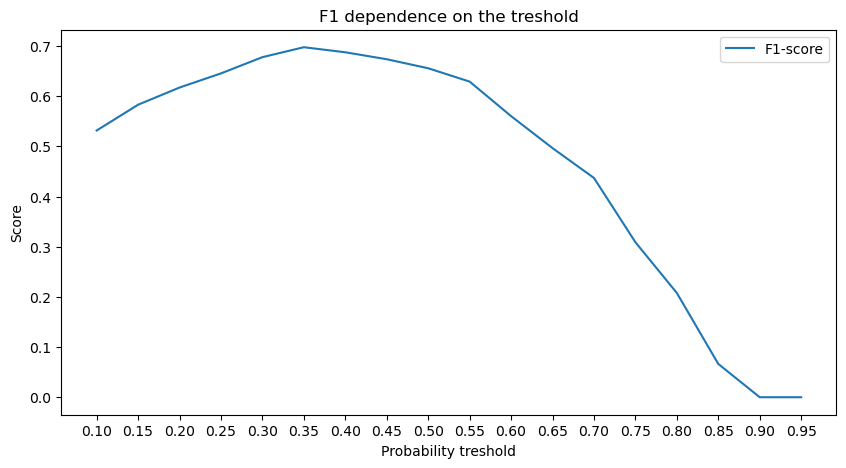

In [297]:
fig, ax = plt.subplots(figsize=(10,5))
#Строим линейный график зависимости F1 от threshold
ax.plot(tresholds, scores, label='F1-score')
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the treshold')
ax.set_xlabel('Probability treshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(tresholds)
#Отображаем легенду
ax.legend();

In [298]:
best_idx = np.argmax(scores)
best_treshold = tresholds[best_idx]
print(best_treshold)

0.3500000000000001


In [299]:
y_test_proba_pred = pd.Series(forest.predict_proba(X_test)[:, 1])
y_pred_test_forest = y_test_proba_pred.apply(lambda x: 1 if x > best_treshold else 0)
print(f'F1-Score для тестовой выборки: {metrics.f1_score(y_test, y_pred_test_forest)}')

F1-Score для тестовой выборки: 0.6975717439293598


Модель можно считать хорошей

Допустим в наш банк пришел некоторый клиент. В базе данных хранятся следующие данные о нем:
```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```


Давайте попробуем спрогнозировать, уйдет ли наш клиент из банка.


In [301]:
client = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})


In [304]:
client['BalanceSalaryRatio'] = client['Balance'] / client['EstimatedSalary']
client['TenureByAge'] = client['Tenure'] / client['Age']
client['CreditScoreGivenAge'] = client['CreditScore'] / client['Age']

client['Gender'] = client['Gender'].apply(lambda x: 0 if x == 'Female' else 1)

In [306]:
client

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
0,601.0,1,42.0,1.0,98495.72,1.0,1.0,0.0,40014.76,2.461485,0.02381,14.309524


In [312]:
p = forest.predict_proba(client)[:, 1]
print(f'Вероятность уходы клиента: {round(p[0]*100,3)}%')

Вероятность уходы клиента: 61.43%
